In [2]:
import osmium
import shapely.wkb as wkblib
import shapely.wkt as wktlib
from shapely.geometry import LineString
import geojson
from functools import reduce

In [3]:
wkbfab = osmium.geom.WKBFactory()

In [4]:
class PlazaHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.plazas = []
        self.ways = []
    def area(self, a):
        if "highway" in a.tags and a.tags["highway"] == "pedestrian":
            wkb = wkbfab.create_multipolygon(a)
            self.plazas.append(wkblib.loads(wkb, hex=True))
    def way(self, w):
        self.ways.append(w.replace())

In [5]:
h = PlazaHandler()

In [6]:
# use idx='dense_mmap_array' for large dataset
h.apply_file("helvetiaplatz.osm", locations=True, idx='sparse_mem_array')

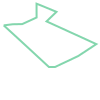

In [7]:
# outer ring of first polygon
plaza_outer = h.plazas[0].geoms[0].exterior
plaza_outer

In [8]:
# inner rings of first polygon
list(h.plazas[0].geoms[0].interiors)

[]

In [9]:
lines = []
for p1 in plaza_outer.coords:
    for p2 in plaza_outer.coords:
        if p1 > p2:
            line = LineString([p1, p2])
            lines.append(line)
len(lines)

152

In [10]:
print(reduce((lambda x, y: '%s\n%s' % (x, y)), [wktlib.dumps(line) for line in lines]))

LINESTRING (8.5264018000000004 47.3760933000000009, 8.5261615000000006 47.3763130000000032)
LINESTRING (8.5264018000000004 47.3760933000000009, 8.5262879999999992 47.3763288000000031)
LINESTRING (8.5264018000000004 47.3760933000000009, 8.5262198999999992 47.3763203000000033)
LINESTRING (8.5264018000000004 47.3760933000000009, 8.5261615000000006 47.3763130000000032)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5261615000000006 47.3763130000000032)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5264018000000004 47.3760933000000009)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5267620999999991 47.3763689000000028)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5266769000000000 47.3765952999999982)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5266219000000003 47.3766168000000008)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5266224000000008 47.3764234000000002)
LINESTRING (8.5267947999999993 47.3757299000000032, 8.5264214000000003 47.376331

In [11]:
geojson.LineString(lines[0].coords)

{"coordinates": [[8.5264018, 47.3760933], [8.5261615, 47.376313]], "type": "LineString"}

In [12]:
geojson_lines = [geojson.Feature(geometry=line) for line in lines]
feature_col = geojson.FeatureCollection(geojson_lines)

In [13]:
with open('helvetiaplatz-lines.geojson', 'w') as fp:
    geojson.dump(feature_col, fp)